In [ ]:
import numpy as np
import torch
from pathlib import Path
from matplotlib import pyplot as plt
from typing import Sequence, Tuple, Union
import time

In [ ]:
def float_tensor(x) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        return x.clone().detach().float()
    
    return torch.tensor(x, dtype=torch.float32)

def train_neuron(
    feats: torch.Tensor,
    lbls: torch.Tensor,
    init_w: torch.Tensor,
    lr: float,
    init_bias: Union[float, int],
    
    epochs: int,
    
    eps: float = 1e-7
) -> Tuple[Sequence[float], float, Sequence[float]]:
    
    w = float_tensor(init_w).view(-1)
    bias = torch.tensor(float(init_bias), dtype=torch.float32)
    feats = float_tensor(feats)
    lbls = float_tensor(lbls).view(-1)
    
    if epochs <= 0 or lr <= 0 or w.shape[0] != feats.shape[1] or feats.shape[0] != lbls.shape[0]:
        raise ValueError('invalid params')
    
    if feats.shape[0] == 0:
        raise ValueError('empty feats')
    
    n_smpls = feats.shape[0]
    nllhist: list[float] = []

    for _ in range(epochs):
        logits = feats @ w + bias
        
        preds = torch.sigmoid(logits)
        probs = torch.clamp(preds, eps, 1.0-eps)
        
        loss  = - (lbls*torch.log(probs) + (1.0-lbls) * torch.log(1.0-probs)
                   ).mean()
        nllhist.append(float(loss))
        err = preds-lbls
        
        grad_w = feats.t() @ err / n_smpls
        grad_b = err.mean()
        
        w -= lr*grad_w
        bias -= lr*grad_b
        
    return w.tolist(), float(bias.item()), nllhist
    

In [ ]:
TRAIN_PATH  = Path.cwd() / 'YearPredictionMSD_train.txt'
TEST_PATH   = Path.cwd() / 'YearPredictionMSD_test.txt'

In [ ]:
def load(
    path: Path,
    neg_year: int, pos_year: int,
    class_samples: Union[None,int]=None,
    
    seed: int = 0
) -> Tuple[torch.Tensor, torch.Tensor]:
    if not path.exists():
        raise FileNotFoundError(f'where is {path}?')
    
    ds = np.loadtxt(path, delimiter=',', dtype=np.float32)
    
    years,feats = ds[:,0], ds[:,1:]
    neg_idxs = np.where(years<neg_year)[0]
    pos_idxs = np.where(years>pos_year)[0]
    
    rng = np.random.default_rng(seed)
    
    neg_smpl = rng.choice(
        neg_idxs, 
        size=min(int(class_samples), neg_idxs.size), 
        replace=False,
    ) if class_samples is not None else neg_idxs
    pos_smpl = rng.choice(
        pos_idxs, 
        size=min(int(class_samples), pos_idxs.size), 
        replace=False,
    ) if class_samples is not None else pos_idxs
    sel_idxs = np.concatenate([neg_smpl, pos_smpl])
    rng.shuffle(sel_idxs)
    return \
        torch.from_numpy(feats[sel_idxs]),\
        torch.from_numpy((years[sel_idxs]==pos_year).astype(np.float32))

In [ ]:
def std_feats(
    feats: torch.Tensor,
    
    eps: float=1e-7,
    
    mean: Union[None, torch.Tensor]=None,
    std: Union[None, torch.Tensor]=None,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if mean is None: mean = feats.mean(dim=0)
    if std is None:  std = feats.std(dim=0)
    adj = torch.where(std<eps, torch.ones_like(std), std)
    return (feats - mean) / adj, mean, adj

In [ ]:
def calc_neuron(
    feats: torch.Tensor,
    w: Union[torch.Tensor, Sequence[float]],
    lbls: torch.Tensor,
    bias: Union[torch.Tensor, float],
    
    eps: float =1e-7,
) -> Tuple[float, float]:
    if isinstance(w, torch.Tensor):
        w = w.detach().float()
    else:
        w=torch.tensor(w, dtype=torch.float32)

    bias = float(bias)
    logits = feats @ w + bias
    probs = torch.clamp(torch.sigmoid(logits), eps, 1.0-eps)
    preds = (
        probs >= .5
    ).float()
    
    nll = -(
        lbls*torch.log(probs) + (1.0-lbls)*torch.log(1.0-probs)
    ).mean().item()
    return nll, (preds==lbls).float().mean().item()

In [ ]:
neg,pos = 1999,2000
train_class_samples = int(6*1000)
test_class_samples = int(2.5*1000)
train_feats,train_lbls = load(
    TRAIN_PATH,
    neg,pos,
    train_class_samples,
    int(time.time())
)
train_feats, mean, std = std_feats(train_feats)
test_feats,test_lbls = load(
    TEST_PATH,
    neg,pos,
    test_class_samples,
    int(time.time())
)
test_feats, _, _ = std_feats(test_feats, mean=mean, std=std)

In [ ]:
print(f'train size: {train_feats.shape}')
print(f'test size: {test_feats.shape}')

train size: torch.Size([12000, 90])
test size: torch.Size([5000, 90])


In [ ]:
torch.manual_seed(int(time.time()))
lr, epochs = .1, 250
init_w = torch.zeros(train_feats.shape[1], dtype=torch.float32)
init_bias = 0.0

upd_w, upd_bias, nllhist = train_neuron(
    train_feats,
    train_lbls,
    init_w,
    lr,
    init_bias,
    epochs,
)

In [ ]:
print(f'nllhist[:6]:', nllhist[:6])
print(f'nllhist[-6:]:', nllhist[-6:])
print(f'bias: {upd_bias:.3f}')


nllhist[:6]: [0.6931472420692444, 0.6684597134590149, 0.6449905633926392, 0.6226778030395508, 0.6014619469642639, 0.5812851190567017]
nllhist[-6:]: [0.04364878311753273, 0.04346673935651779, 0.04328617453575134, 0.043107084929943085, 0.04292943701148033, 0.04275321960449219]
bias: -3.135


In [ ]:
tensor_w = torch.tensor(upd_w, dtype=torch.float32)
nlltrain,acctrain = calc_neuron(
    train_feats, tensor_w, train_lbls, upd_bias
)
nlltest,acctest = calc_neuron(
    test_feats, tensor_w, test_lbls, upd_bias
)

In [ ]:
print(f'train nll: {nlltrain:.3f}, acc: {acctrain:.4f}')
print(f'train nll: {nlltest:.3f}, acc: {acctest:.4f}')

train nll: 0.043, acc: 1.0000
train nll: 0.043, acc: 1.0000


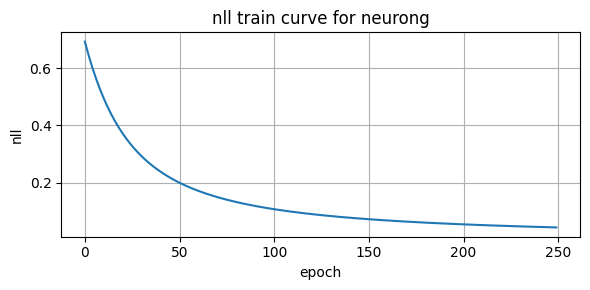

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(range(len(nllhist)), nllhist)
plt.xlabel('epoch')
plt.ylabel('nll')
plt.title('nll train curve for neurong')
plt.grid(True)
plt.tight_layout()

plt.show()

Synthetic data


In [ ]:
torch.manual_seed(int(time.time()))
class_samples = 250

sneg = torch.tensor([-5.0,-1.0])+.8*torch.randn(class_samples,2)
spos = torch.tensor([+5.0,+1.5])+.8*torch.randn(class_samples,2)
sfeats = torch.cat([sneg,spos],dim=0)
slbls  = torch.cat([
    torch.zeros(class_samples),
    torch.ones(class_samples)
])

sfeats, smean, sstd = std_feats(sfeats)
sinit_w = torch.zeros(sfeats.shape[1])
slr, sepochs = .12, 100
sw,sbias, snll = train_neuron(
    sfeats, slbls, sinit_w, slr, 0.0, sepochs
)
stensor_w = torch.tensor(sw)

snll_val, sacc = calc_neuron(
    sfeats, stensor_w, slbls, sbias
)


In [ ]:
print(f'nll: {snll_val:.3f}, acc: {sacc:.4f}')

nll: 0.071, acc: 1.0000


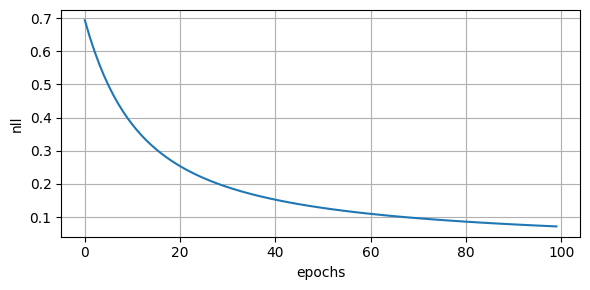

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(snll)
plt.xlabel('epochs')
plt.ylabel('nll')
plt.grid(True)
plt.tight_layout()
plt.show()

Mini-Batch 

In [ ]:
def train_neuron_mbatch(
    feats: torch.Tensor,
    lbls: torch.Tensor,
    init_w: torch.Tensor,
    lr: float,
    init_bias: Union[float, int],
    
    epochs: int,
    batch_size: int,
    
    eps: float = 1e-7
) -> Tuple[Sequence[float], float, Sequence[float]]:
    
    w = float_tensor(init_w).view(-1)
    bias = torch.tensor(float(init_bias), dtype=torch.float32)
    feats = float_tensor(feats)
    lbls = float_tensor(lbls).view(-1)
    
    n_smpls = feats.shape[0]
    nllhist: list[float] = []
    batch_size = min(batch_size, n_smpls)
    
    for _ in range (epochs):
        perm = torch.randperm(n_smpls)
        
        feats_sh = feats[perm]
        lbls_sh  = lbls[perm]
        
        epoch_loss = .0
        for i in range(0,n_smpls,batch_size):
            j = i+batch_size
            
            bfeats = feats_sh[i:j]
            blbls  = lbls_sh[i:j]
            
            logits = bfeats @ w+ bias
            preds  = torch.sigmoid(logits)
            probs  = torch.clamp(preds, eps, 1.0-eps)

            epoch_loss += float(
                -(blbls*torch.log(probs)
                  +(1.0-blbls)*torch.log(1.0-probs)
).mean()   
            )*bfeats.shape[0]
            
            err = preds-blbls
            
            grad_w = bfeats.t() @ err / bfeats.shape[0]
            grad_b = err.mean()
            
            w -= lr*grad_w
            bias -= lr*grad_b
        
        nllhist.append(float(epoch_loss/n_smpls))
    return w.tolist(), float(bias.item()), nllhist


In [ ]:

epochs = 300
lr = .09

batch_size = 128

init_w = torch.zeros(train_feats.shape[1])
init_bias = .0

In [ ]:
w1, bias1, hist1 = train_neuron(
    train_feats, train_lbls,
    init_w, lr, init_bias,
    epochs
)
w2, bias2, hist2 = train_neuron_mbatch(
    train_feats, train_lbls,
    init_w, lr, init_bias,
    epochs, batch_size
)

nlltrain1, acctrain1 = calc_neuron(
    train_feats, torch.tensor(w1), train_lbls, bias1
)
nlltest1, acctest1 = calc_neuron(
    test_feats, torch.tensor(w1), test_lbls, bias1
)

nlltrain2, acctrain2 = calc_neuron(
    train_feats, torch.tensor(w2), train_lbls, bias2
)
nlltest2, acctest2 = calc_neuron(
    test_feats, torch.tensor(w2), test_lbls, bias2
)



In [ ]:
print(f'fullbatch: nlltrain: {nlltrain1:.3f}, acctrain: {acctrain1:.4f}')
print(f'fullbatch: nlltest:  {nlltest1:.3f}, acctest:  {acctest1:.4f}')
print(f'mbatch:    nlltrain: {nlltrain2:.3f}, acctrain: {acctrain2:.4f}')
print(f'mbatch:    nlltest:  {nlltest2:.3f}, acctest:  {acctest2:.4f}')


fullbatch: nlltrain: 0.039, acctrain: 1.0000
fullbatch: nlltest:  0.039, acctest:  1.0000
mbatch:    nlltrain: 0.000, acctrain: 1.0000
mbatch:    nlltest:  0.000, acctest:  1.0000


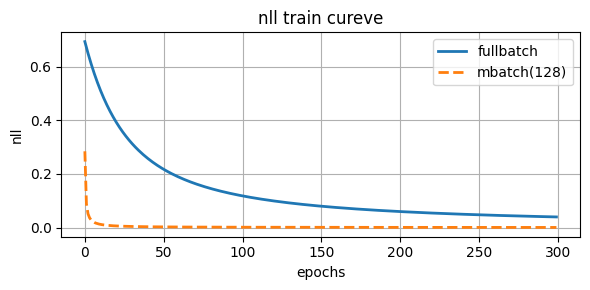

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(hist1, label='fullbatch', linewidth=2)
plt.plot(hist2, label=f'mbatch({batch_size})', linestyle='--', linewidth=2)
plt.xlabel('epochs')
plt.ylabel('nll')
plt.title('nll train cureve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

comparasion with 

In [ ]:
samples = 600
x1,x2 = 18*torch.randn(samples), 0.18*torch.randn(samples)
feats = torch.stack([x1,x2], dim=1)
w,b = torch.tensor([.45, -2.8]), -.3
probs = torch.sigmoid(feats@w+b)
lbls  = (torch.rand(samples) < probs).float()

feats_norm,mean,std = std_feats(feats)

epochs = 300
lr_raw = 0.02
lr_std = 0.2
batch_size = 64
init_w = torch.zeros(feats.shape[1])

w1, b1, hist1 = train_neuron(
    feats, lbls, init_w, lr_raw, .0, epochs
)
w2, b2, hist2 = train_neuron_mbatch(
    feats, lbls, init_w, lr_raw, .0, epochs, batch_size
)

w3, b3, hist3 = train_neuron(
    feats_norm, lbls, init_w, lr_std, .0, epochs
)
w4, b4, hist4 = train_neuron_mbatch(
    feats_norm, lbls, init_w, lr_std, .0, epochs, batch_size
)

w1_nll, w1_acc = calc_neuron(
    feats, torch.tensor(w1), lbls, b1
)
w2_nll, w2_acc = calc_neuron(
    feats, torch.tensor(w2), lbls, b2
)
w3_nll, w3_acc = calc_neuron(
    feats_norm, torch.tensor(w3), lbls, b3
)
w4_nll, w4_acc = calc_neuron(
    feats_norm, torch.tensor(w4), lbls, b4
)
print(f'no-std, fullbatch (lr={lr_raw}):  nll: {w1_nll:.4f}, acc: {w1_acc:.4f}')
print(f'no-std, mbatch   (lr={lr_raw}):  nll: {w2_nll:.4f}, acc: {w2_acc:.4f}')
print(f'std, fullbatch   (lr={lr_std}): nll: {w3_nll:.4f}, acc: {w3_acc:.4f}')
print(f'std, mbatch      (lr={lr_std}): nll: {w4_nll:.4f}, acc: {w4_acc:.4f}')



no-std, fullbatch (lr=0.02):  nll: 0.1843, acc: 0.9250
no-std, mbatch   (lr=0.02):  nll: 0.1827, acc: 0.9233
std, fullbatch   (lr=0.2): nll: 0.2037, acc: 0.9200
std, mbatch      (lr=0.2): nll: 0.1775, acc: 0.9200


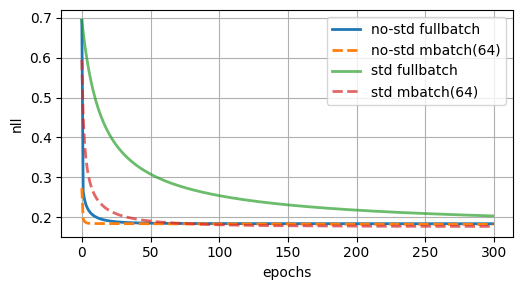

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(hist1, label='no-std fullbatch', linewidth=2)
plt.plot(hist2, label=f'no-std mbatch({batch_size})', linewidth=2, linestyle='--')
plt.plot(hist3, label='std fullbatch', linewidth=2, alpha=.7)
plt.plot(hist4, label=f'std mbatch({batch_size})', linewidth=2, linestyle='--', alpha=.7)
plt.xlabel('epochs')
plt.ylabel('nll')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

В итоге minibatch ускоряет обучение, но +- в нашем случае близок к fullbatch на больших эпохах